# Team 11 SC3000 Lab Assignment 1

# Team Contributions:
Lim Yu Cheng, Bryan: <br>(1) Development of RL Agent & Tuning of Hyperparameters<br>
(2) Demonstrate the effectiveness of the RL agent <br>
(4) Formatting Jupyter Notebook <br>
<br>
Lim Yee Herng Reuben: <br>
(1) Tuning of Hyperparameters <br>
(2) Demonstrate the effectiveness of the RL agent <br>
(3) Render one episode played by the developed RL agent

# Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install numpy==1.26
!pip install gym==0.26.2
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

# Import dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from IPython.display import Video

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

# Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

Check action and observation space of the environment. Discrete(2) means that there are two valid discrete actions: 0 & 1. <br>
The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


Each round of the pole-balancing game is called an "Episode". At the start of each episode, ensure to reset the environment with env.reset(), which chooses a random initial state of the cartpole. An instance of this is shown with the code below.

In [ ]:
observation, info = env.reset()
print("Initial observations:", observation)

Initial observations: [0.02352606 0.00375993 0.00928413 0.04964504]


For the CartPole environment, there are two possible actions: 0 for pushing the cart to the left and 1 for pushing to the right. For example, we can push the cart to the left using the code below, which returns the new observation, current reward, an indicator of whether the episode has ended, and some additional information (Not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e max cumulative reward is 500).

In [ ]:
observation, reward, done, info, _ = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.02360126 -0.19149391  0.01027703  0.34524268]
Reward for this step: 1.0
Is this round done? False


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Now, we will play a full round of the game using a naive strategy (always choosing action 0 to push the cart left), and show the cumulative reward in the round. The reward return by env.step() corresponds to the reward for the current step (which is 1 reward). So we have to accumulate the reward for each step. The naive strategy expectedly performs poorly by surviving ~9 steps.

In [ ]:
observation, info = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info, _ = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 8.0




---



# Task 1: Development of an RL agent.

Firstly, we define the boundaries of the action space as mentioned by the Problem Statement. For cart_velocity and pole_velocity, we set the minimum and maximum values to be -4.0 and 4.0 respectively for both as infinite is not a valid value.

In [ ]:
# Define the bounds for each state dimension
min_cart_position = -2.4
min_cart_velocity = -4.0
min_pole_angle = -0.2095
min_pole_velocity = -4.0

max_cart_position = 2.4
max_cart_velocity = 4.0
max_pole_angle = 0.2095
max_pole_velocity = 4.0

lower_bounds = [min_cart_position, min_cart_velocity, min_pole_angle, min_pole_velocity]
upper_bounds = [max_cart_position, max_cart_velocity, max_pole_angle, max_pole_velocity]

We chose to use a **Q-Learning Agent** as our Reinforcement Learning Agent. A Q-Learning Agent learns an optimal policy for decision-making by interacting with the environment and updating its policy after every step (i.e After choosing an action at a state, update the Q-Table based on the rewards and the viability of the next state).

Since the states are continuous values, we need to set bins to discretise the cart’s observation state, which includes cart position, cart velocity, pole angle, and pole velocity. Else, storing them in the Q table without discretisation would result in an infinitely large table.

The larger the number of bins, the larger the Q table will be, and the more accurate the Agent will become. But too large number of bins is unfeasible due to the exponentially larger Q table needed, as well as the slower learning of the Agent due to needing to explore a larger number of states. But too little number of bins results in loss of granularity in state representation, which can lead to the Agent failing to learn optimal policies or generalising poorly to certain states. With too few bins, the Agent ends up treating a wide range of states as equivalent, thus losing the ability to make fine distinctions between states that could require different actions.

As such, we chose 10 bins per state dimension which is a reasonable number of bins to split the observation space into, giving 10^4 (10000) different states.

In [ ]:
# Define the number of bins for each state dimension
n_bins = (10,10,10,10)

Next, we define our Q-Learning Agent with the necessary functions to perform Q-learning, following the algorithm given in the Content Slides. <br>
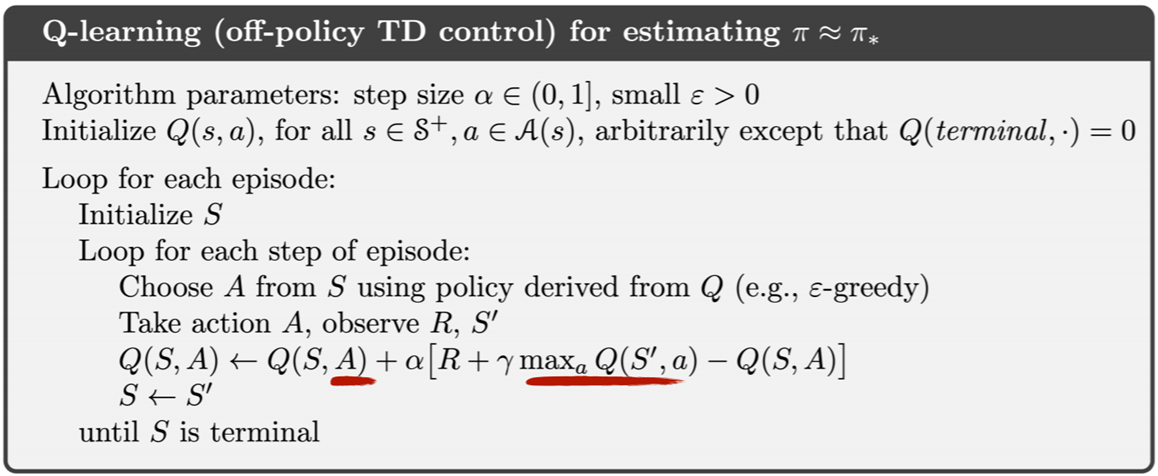
1.   Initialising the Q-Table upon creation of Q_Agent.
2.   policy() function to select the action at a given state using an epsilon-greedy policy.
3.   new_Q() function to update the Q-values in the Q_table based on the Bellman equation, improving the Q-Learning Agent's decision making.

We also included:
1.   discretiser() function to discretise the 4 variables of a state into their respective bins, returning a tuple of the 4 indexes of the variables (cart position, cart velocity, pole angle, and pole velocity).
2.   training() function to train the Q-Learning Agent based on the specified numberOfEpisodes. The Agent will play through the X number of episodes, training itself by updating the Q-Table to improve its decision making.
3.   runTrainedAgent() function for Task 2, where the Trained Q-Learning Agent plays a specified numberOfEpisodes with its trained Q-Table **without** anymore learning.
4.   returnAvgRewardsEpisode() function to return the average episode rewards for graph plotting.


In [ ]:
class Q_Agent:
  def __init__(self, env, alpha, gamma, epsilon, numberOfBins, lower_bounds, upper_bounds):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.epsilon_decay = 0.00001
    self.actionNumber = self.env.action_space.n
    self.cart_pos_space = np.linspace(lower_bounds[0], upper_bounds[0], numberOfBins[0])
    self.cart_vel_space = np.linspace(lower_bounds[1], upper_bounds[1], numberOfBins[1])
    self.pole_ang_space = np.linspace(lower_bounds[2], upper_bounds[2], numberOfBins[2])
    self.pole_ang_vel_space = np.linspace(lower_bounds[3], upper_bounds[3], numberOfBins[3])

    self.avgRewardsEpisode = []

    self.Q_table = np.zeros((len(self.cart_pos_space), len(self.cart_vel_space), len(self.pole_ang_space), len(self.pole_ang_vel_space), self.actionNumber))


# Discretiser to sort each variable into discrete indexes.
# Returns tuple of state indexes.
  def discretiser(self, state):
    cart_position_index = np.digitize(state[0], self.cart_pos_space) - 1
    cart_velocity_index = np.digitize(state[1], self.cart_vel_space) - 1
    pole_angle_index = np.digitize(state[2], self.pole_ang_space) - 1
    pole_velocity_index = np.digitize(state[3], self.pole_ang_vel_space) - 1

    return (cart_position_index, cart_velocity_index, pole_angle_index, pole_velocity_index)

# Epsilon-greedy policy to determine action taken at a given state.
  def policy(self, state):
    if random.uniform(0,1) < self.epsilon:
      return np.random.randint(0, self.actionNumber)
    else:
      state_index = self.discretiser(state)
      state_p = state_index[0]
      state_v = state_index[1]
      state_a = state_index[2]
      state_av = state_index[3]
      return np.argmax(self.Q_table[state_p, state_v, state_a, state_av, :])

# Calculation of new Q(S,a)
  def new_Q(self, reward, current_state, action, next_state):
    current_state_index = self.discretiser(current_state)
    current_state_p = current_state_index[0]
    current_state_v = current_state_index[1]
    current_state_a = current_state_index[2]
    current_state_av = current_state_index[3]

    next_state_index = self.discretiser(next_state)
    new_state_p = next_state_index[0]
    new_state_v = next_state_index[1]
    new_state_a = next_state_index[2]
    new_state_av= next_state_index[3]

    current_q = self.Q_table[current_state_p, current_state_v, current_state_a, current_state_av, action]
    next_q = np.max(self.Q_table[new_state_p, new_state_v, new_state_a, new_state_av,:])

    self.Q_table[current_state_p, current_state_v, current_state_a, current_state_av, action] = current_q + self.alpha*(reward + self.gamma*(next_q) - current_q)

# Training the agent for X (numberOfEpisodes) episodes, updating Q table with Bellman Equation and decaying Epsilon by rate of -0.00001 per episode.
  def training(self, numberOfEpisodes):
    for i in range(int(numberOfEpisodes/100)):
      sumRewardsEpisode = 0
      for _ in range(100):
        state, info = self.env.reset()
        done = False
        rewardEpisode = 0
        while not done:
          action = self.policy(state)
          new_state, reward, done, info, _ = self.env.step(action)
          self.new_Q(reward, state, action, new_state)
          state = new_state
          rewardEpisode += reward
          if rewardEpisode == 500:
            done = True
        sumRewardsEpisode += rewardEpisode
        self.epsilon = max(0.01, self.epsilon - self.epsilon_decay)
      self.avgRewardsEpisode.append(sumRewardsEpisode/100)


# Running the trained agent for X (numberEpisodes) episodes without updating Q table, action chosen is ENTIRELY based on Q-Table, and no decaying Epsilon. Returning the cumulative rewards of each episode ran.
  def runTrainedAgent(self, numberOfEpisodes):
    originalE = self.epsilon
    self.epsilon = 0

    sumRewardsEpisode = []
    for _ in range(numberOfEpisodes):
      state, info = self.env.reset()
      done = False
      rewardEpisode = 0
      while not done:
        state = self.discretiser(state)
        action = np.argmax(self.Q_table[state[0], state[1], state[2], state[3], :])
        new_state, reward, done, info, _ = self.env.step(action)
        state = new_state
        rewardEpisode += reward
        if rewardEpisode == 500:
            done = True
      sumRewardsEpisode.append(rewardEpisode)

    self.epsilon = originalE
    return sumRewardsEpisode

# Return function for avgRewardsEpisodes
  def returnAvgRewardsEpisode(self):
    return self.avgRewardsEpisode


# Tuning hyperparameters **α** alpha (Learning Rate), **γ** gamma (Discount Factor) and **ε** epsilon (Exploration Rate) to find out their optimal values.

We will be testing the following parameter sets: <br>
<br>
agent_0: α=0.1, γ=0.95, ε=0.99 Base parameters <br>
agent_1: α=0.3, γ=0.95, ε=0.99 Higher Learning Rate <br>
agent_2: α=0.1, γ=0.99, ε=0.99 Higher Discount Factor <br>
agent_3: α=0.1, γ=0.95, ε=0.8 Lower Exploration Rate <br>
<br>
Then pick the best performing agent.

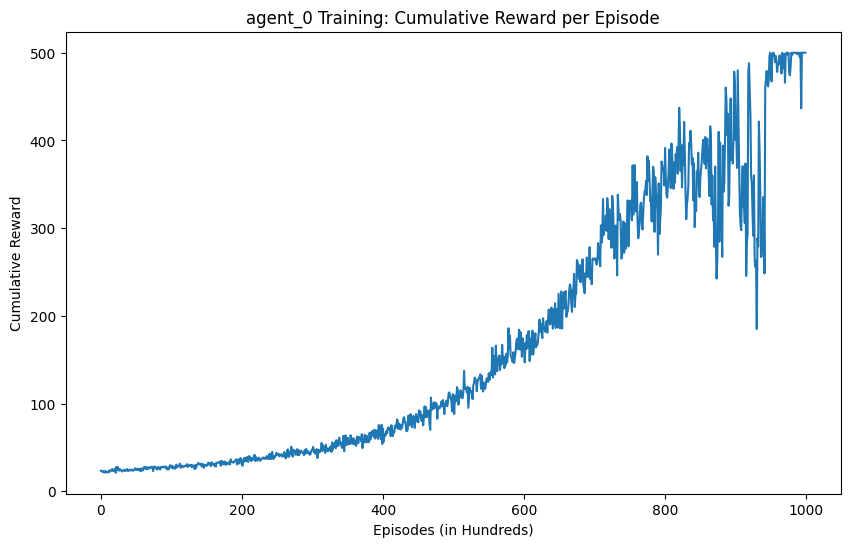

Average Cumulative Reward at the 100000th Episode: 426.38


In [ ]:
# Initialising Agents
agent_0 = Q_Agent(env, 0.1, 0.95, 0.99, n_bins, lower_bounds, upper_bounds)
agent_0.training(100000) # ~30mins
results = agent_0.returnAvgRewardsEpisode()

plt.figure(figsize=(10, 6))
plt.plot(results)
plt.title(f'agent_0 Training: Cumulative Reward per Episode')
plt.ylabel('Cumulative Reward')
plt.xlabel('Episodes (in Hundreds)')
plt.show()
print(f'Average Cumulative Reward at the 100000th Episode: {np.mean(results[-100:]):.2f}')

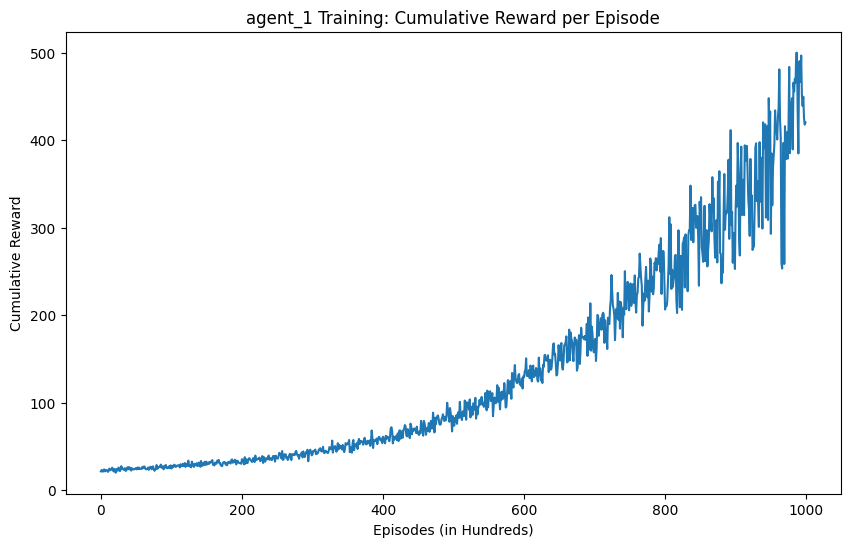

Average Cumulative Reward at the 100000th Episode: 382.06


In [ ]:
agent_1 = Q_Agent(env, 0.3, 0.95, 0.99, n_bins, lower_bounds, upper_bounds)
agent_1.training(100000)
results = agent_1.returnAvgRewardsEpisode()

plt.figure(figsize=(10, 6))
plt.plot(results)
plt.title(f'agent_1 Training: Cumulative Reward per Episode')
plt.ylabel('Cumulative Reward')
plt.xlabel('Episodes (in Hundreds)')
plt.show()
print(f'Average Cumulative Reward at the 100000th Episode: {np.mean(results[-100:]):.2f}')

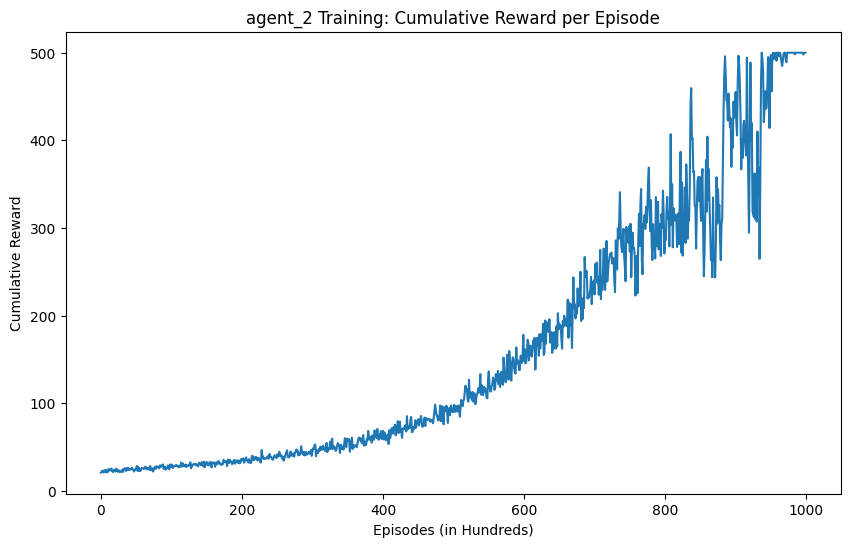

Average Cumulative Reward at the 100000th Episode: 453.65


In [ ]:
agent_2 = Q_Agent(env, 0.1, 0.99, 0.99, n_bins, lower_bounds, upper_bounds)
agent_2.training(100000)
results = agent_2.returnAvgRewardsEpisode()

plt.figure(figsize=(10, 6))
plt.plot(results)
plt.title(f'agent_2 Training: Cumulative Reward per Episode')
plt.ylabel('Cumulative Reward')
plt.xlabel('Episodes (in Hundreds)')
plt.show()
print(f'Average Cumulative Reward at the 100000th Episode: {np.mean(results[-100:]):.2f}')

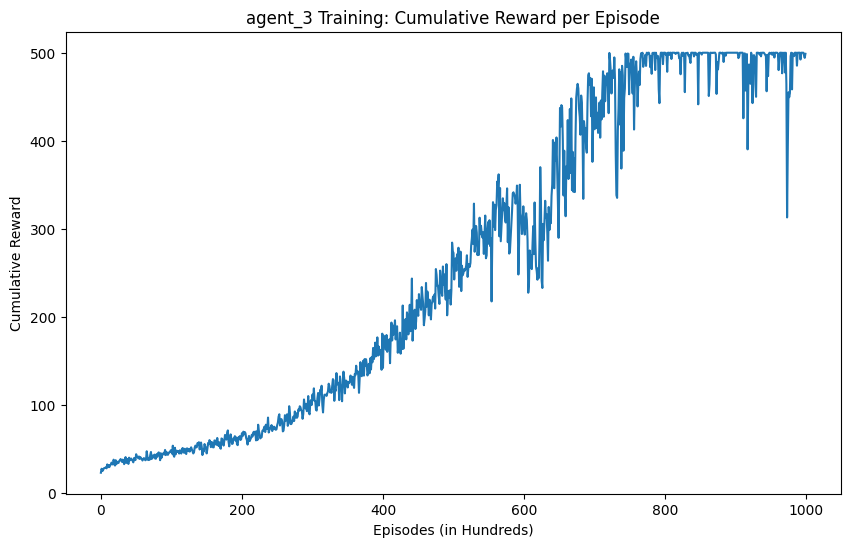

Average Cumulative Reward at the 100000th Episode: 487.46


In [ ]:
agent_3 = Q_Agent(env, 0.1, 0.95, 0.80, n_bins, lower_bounds, upper_bounds)
agent_3.training(100000)
results = agent_3.returnAvgRewardsEpisode()

plt.figure(figsize=(10, 6))
plt.plot(results)
plt.title(f'agent_3 Training: Cumulative Reward per Episode')
plt.ylabel('Cumulative Reward')
plt.xlabel('Episodes (in Hundreds)')
plt.show()
print(f'Average Cumulative Reward at the 100000th Episode: {np.mean(results[-100:]):.2f}')

# Analysis of Graphs
agent_3 appears to be the agent with the best hyperparameters, achieving the highest Average Cumulative Reward at the 100000th Episode of 487. agent_3 also has the fastest training improvement, as shown by how quickly it reached higher cumulative rewards. As such, we will be using agent_3 for Task 2 & 3. <br>
<br>
agent_0 performed slightly worse than agent_3, showing that high exploration rate leads to slow learning of the Agent. This is due to the Agent taking longer to transition to Exploitation, delaying optimal policy convergence. <br>
<br>
agent_1 performed much worse than all the agents, with the lowest Average Cumulative Reward at the 100000th Episode of 382. This is due to the higher learning rate of agent_1 resulting in a suboptimal policy convergence. <br>
<br>
agent_2 performed slightly worse than agent_3, but slightly better than agent_0. The higher discount factor places more emphasis on future rewards, resulting in faster learning of agent_2 as compared to agent_0.

# We will be using agent_3, which was trained using following hyperparameters, for Task 2 & 3. <br>
Learning Rate **α, alpha** = 0.1<br>

Discount Factor **γ, gamma** = 0.95<br>

Epsilon Rate **ε, epsilon** = 0.80<br>


In [ ]:
agent = agent_3

# Demonstrate the correctness of the implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action. Print the values of the state and chosen action in Jupyter notebook.

In [ ]:
# Implementation
state, info = env.reset()
action = agent.policy(state)
print("State: ", state)
print("Chosen action at state: ", action)

State:  [-0.04853481  0.01270903  0.03038453  0.04625102]
Chosen action at state:  1




---



# Task 2: Demonstrate the effectiveness of the Q-Learning Agent.

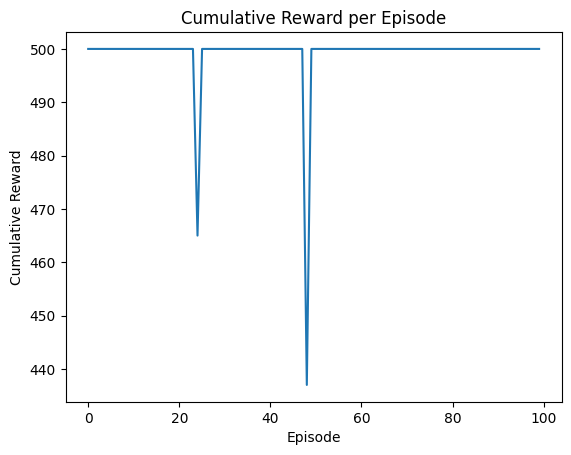

Average cumulative reward:  499.02
Is my agent good enough?  True


In [ ]:
# Demonstrate effectiveness of Q-Learning Agent by running Trained Agent for 100 episodes and plotting cumulative reward per episode.
episode_results = agent.runTrainedAgent(100)
plt.plot(episode_results)
plt.title('Cumulative Reward per Episode')
plt.ylabel('Cumulative Reward')
plt.xlabel('Episode')
plt.show()
print("Average cumulative reward: ", np.mean(episode_results))
print("Is my agent good enough? ", np.mean(episode_results) > 195)

After running 100 episodes of our Trained Q-Learning Agent, the average cumulative reward over the 100 episodes is much higher than 195, showing that our Trained Q-Learning Agent is very successfully trained.



---



# Task 3: Render one episode played by the Trained Q-Learning agent on Jupyter.

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

video_dir = "/content/video"
env = RecordVideo(env, video_dir, episode_trigger=lambda episode: True)

observation, info = env.reset()

while True:
    action = agent.policy(observation)
    observation, reward, done, info, _ = env.step(action)
    if done:
      break

env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4
